In [23]:
#Team Though Experiment
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from scipy.signal import welch

In [2]:
dftr = pd.read_csv(r'C:\Users\aveng\Downloads\mergedtrain\merged.csv')

In [3]:
dfte = pd.read_csv(r'C:\Users\aveng\Downloads\mergedtest\mergedtest.csv')

In [4]:
dftr_values = dftr['5000']
dfte_values = dfte['5000']
dftr = dftr.drop('5000', axis = 1)
dfte = dfte.drop('5000', axis = 1)

In [5]:
def impute_outliers(series):
    mean_val = series.mean()
    std_val = series.std()
    
    lower_bound = mean_val - 3 * std_val
    upper_bound = mean_val + 3 * std_val
    
    # Replace outliers with values within the specified range
    series[series < lower_bound] = lower_bound
    series[series > upper_bound] = upper_bound
    return series

In [6]:
dftr_numeric = dftr.select_dtypes(include=[np.number])
dftr_imputed = dftr_numeric.apply(impute_outliers)
dftr = dftr_imputed

In [7]:
dfte_numeric = dfte.select_dtypes(include=[np.number])
dfte_imputed = dfte_numeric.apply(impute_outliers)
dfte = dfte_imputed

In [8]:
delta_band = (1,4)
theta_band = (5,9)
low_beta_band = (10,20)
high_beta_band = (21,40)

In [9]:
def calculate_band_power(eeg_data, sf, band):
    freqs, psd = welch(eeg_data, sf, nperseg=10*sf)  # Using 10 seconds for segment length
    band_freqs = (freqs >= band[0]) & (freqs <= band[1])
    band_power = np.trapz(psd[band_freqs], freqs[band_freqs])
    return band_power

In [10]:
dftr["delta_power"] = dftr.apply(lambda x: calculate_band_power(x, 500, delta_band), axis=1)
dftr["theta_power"] = dftr.apply(lambda x: calculate_band_power(x, 500, theta_band), axis=1)
dftr["low_beta_power"] = dftr.apply(lambda x: calculate_band_power(x, 500, low_beta_band), axis=1)
dftr["high_beta_power"] = dftr.apply(lambda x: calculate_band_power(x, 500, high_beta_band), axis=1)
dftr["theta_to_delta_ratio"] = dftr.apply(lambda x: x["theta_power"] / x["delta_power"], axis = 1)
dftr["low_beta_to_delta_ratio"] = dftr.apply(lambda x: x["low_beta_power"] / x["delta_power"], axis = 1)
dftr["high_beta_to_delta_ratio"] = dftr.apply(lambda x: x["high_beta_power"] / x["delta_power"], axis = 1)

In [11]:
dfte["delta_power"] = dfte.apply(lambda x: calculate_band_power(x, 500, delta_band), axis=1)
dfte["theta_power"] = dfte.apply(lambda x: calculate_band_power(x, 500, theta_band), axis=1)
dfte["low_beta_power"] = dfte.apply(lambda x: calculate_band_power(x, 500, low_beta_band), axis=1)
dfte["high_beta_power"] = dfte.apply(lambda x: calculate_band_power(x, 500, high_beta_band), axis=1)
dfte["theta_to_delta_ratio"] = dfte.apply(lambda x: x["theta_power"] / x["delta_power"], axis = 1)
dfte["low_beta_to_delta_ratio"] = dfte.apply(lambda x: x["low_beta_power"] / x["delta_power"], axis = 1)
dfte["high_beta_to_delta_ratio"] = dfte.apply(lambda x: x["high_beta_power"] / x["delta_power"], axis = 1)

In [14]:
X_train = dftr[['delta_power', 'theta_power', 'low_beta_power', 'high_beta_power', 'theta_to_delta_ratio', 'low_beta_to_delta_ratio', 'high_beta_to_delta_ratio']]
y_train = dftr_values

In [15]:
X_test = dfte[['delta_power', 'theta_power', 'low_beta_power', 'high_beta_power', 'theta_to_delta_ratio', 'low_beta_to_delta_ratio', 'high_beta_to_delta_ratio']]
y_test = dfte_values

In [16]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)
scaled_df = pd.DataFrame(scaled_data, columns=X_train.columns)
X_train = scaled_df

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_test)
scaled_df = pd.DataFrame(scaled_data, columns=X_test.columns)
X_test = scaled_df

In [32]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train);
y_pred = lr.predict(X_test)
print(round(accuracy_score(y_test, y_pred)*100,5), "%")

67.53858 %


In [33]:
cnf_matrix_xgo = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_xgo

array([[ 2578,   136,   340],
       [  965, 21218,   778],
       [10513,  4096, 11216]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

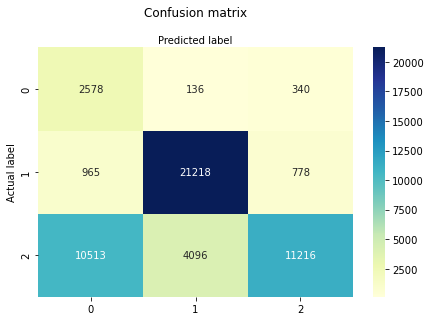

In [34]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_xgo), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [35]:
#xgb optimized
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.6753858024691358
              precision    recall  f1-score   support

           0       0.18      0.84      0.30      3054
           1       0.83      0.92      0.88     22961
           2       0.91      0.43      0.59     25825

    accuracy                           0.68     51840
   macro avg       0.64      0.73      0.59     51840
weighted avg       0.83      0.68      0.70     51840



In [24]:
# AdaBoost with DecisionTreeClassifier as base estimator
adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# Define the parameter grid for AdaBoost
param_grid_adaboost = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5]
}

# Setup K-Fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Random search of parameters using K-Fold CV
random_search_adaboost = RandomizedSearchCV(estimator=adaboost_model, param_distributions=param_grid_adaboost, n_iter=50, cv=kf, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
random_search_adaboost.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_adaboost.best_params_)
print("Best Score:", random_search_adaboost.best_score_)

# Use the best estimator to make predictions
best_adaboost_model = random_search_adaboost.best_estimator_
adaboost_predictions = best_adaboost_model.predict(X_test)

C:\Users\aveng\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 50, 'learning_rate': 0.01}
Best Score: 0.8200347222222222


In [28]:
cnf_matrix_xgo = metrics.confusion_matrix(y_test, adaboost_predictions)
cnf_matrix_xgo

array([[ 1381,   143,  1530],
       [  457, 16442,  6062],
       [ 6210,  2799, 16816]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

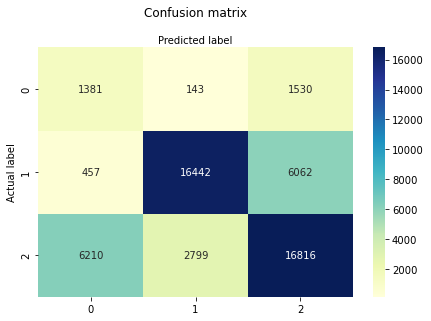

In [29]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_xgo), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
#xgb optimized
accuracy = accuracy_score(y_test, adaboost_predictions)
print(f"Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, adaboost_predictions))

Accuracy: 0.668190586419753
              precision    recall  f1-score   support

           0       0.17      0.45      0.25      3054
           1       0.85      0.72      0.78     22961
           2       0.69      0.65      0.67     25825

    accuracy                           0.67     51840
   macro avg       0.57      0.61      0.56     51840
weighted avg       0.73      0.67      0.69     51840



In [18]:
#XGBM 2 optimized
xgbmo = xgb.XGBClassifier(objective='multi:softprob', num_class=3, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#Add in cross validation
#Setup K-Fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

#Random search of parameters using K-Fold CV
random_search = RandomizedSearchCV(estimator=xgbmo, param_distributions=param_grid, n_iter=50, cv=kf, verbose=2, random_state=42, n_jobs=-1)

#Fit the random search model
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Use the best estimator to make predictions
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best Score: 0.8825694444444444


In [19]:
cnf_matrix_xgo = metrics.confusion_matrix(y_test, predictions)
cnf_matrix_xgo

array([[ 1354,    98,  1602],
       [  179, 18453,  4329],
       [ 2695,  1924, 21206]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

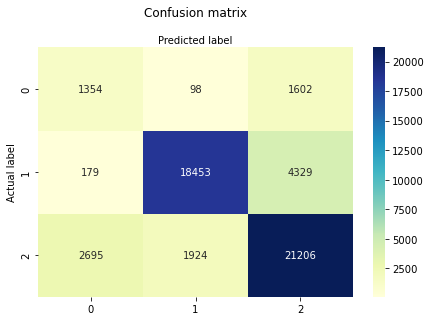

In [20]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_xgo), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
#xgb optimized
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(y_test, predictions))

Accuracy: 0.7911458333333333
              precision    recall  f1-score   support

           0       0.32      0.44      0.37      3054
           1       0.90      0.80      0.85     22961
           2       0.78      0.82      0.80     25825

    accuracy                           0.79     51840
   macro avg       0.67      0.69      0.67     51840
weighted avg       0.81      0.79      0.80     51840



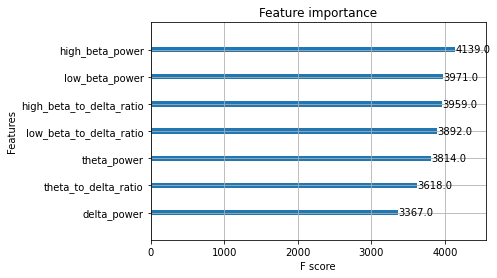

In [22]:
xgb.plot_importance(best_model, max_num_features = 7)
plt.show()